In [ ]:
# Load packages
library(lme4)
library(pbkrtest)
library(ggplot2)
library(sjPlot)
library(dplyr)
library(patchwork)
library(pwr)
library(emmeans)
library(lmerTest)

# Load data

In [4]:
# Load Data
new_table_ad_filtered <- read.csv("data/new_table_adas_withCov.csv") #ADAS
new_table_cdr_filtered <- read.csv("data/new_table_cdr_withCov.csv") #CDR
new_table_amyloid <- read.csv("data/new_table_withCov.csv") #Amyloid

# Calculate change in scores

In [5]:
# Calculate changes over time: week 104 - week 1

# CDR CHANGE
# Filter rows with time_point=1 and time_point=104
am_cdr_1 <- subset(new_table_cdr_filtered, time_point == 1)
am_cdr_104 <- subset(new_table_cdr_filtered, time_point == 104)

# Merge the two subsets based on the EID column
am_cdr_change <- merge(am_cdr_1, am_cdr_104, by = "EID", suffixes = c("_1", "_104"))

# Calculate the change in CDR_SOB
am_cdr_change$CDR_SOB_change <- am_cdr_change$CDR_SOB_104 - am_cdr_change$CDR_SOB_1

# Selecting specific columns
selected_columns <- c("EID", "Treatment_Information_1", "ad_category_1", "CDR_SOB_change")

# Subset the data with selected columns
am_cdr_change_subset <- am_cdr_change[, selected_columns]

In [6]:
cdr_change_slow <- subset(am_cdr_change_subset, ad_category_1 == "Slow")
cdr_change_rapid <- subset(am_cdr_change_subset, ad_category_1 == "Rapid")

# Subset data for Treatment_Information='Placebo' and '50 mg'
cdr_change_placebo <- subset(am_cdr_change_subset, Treatment_Information_1 == "Placebo")
cdr_change_50mg <- subset(am_cdr_change_subset, Treatment_Information_1 == "LY3314814-50mg")

# Power curve analysis

png 
  2

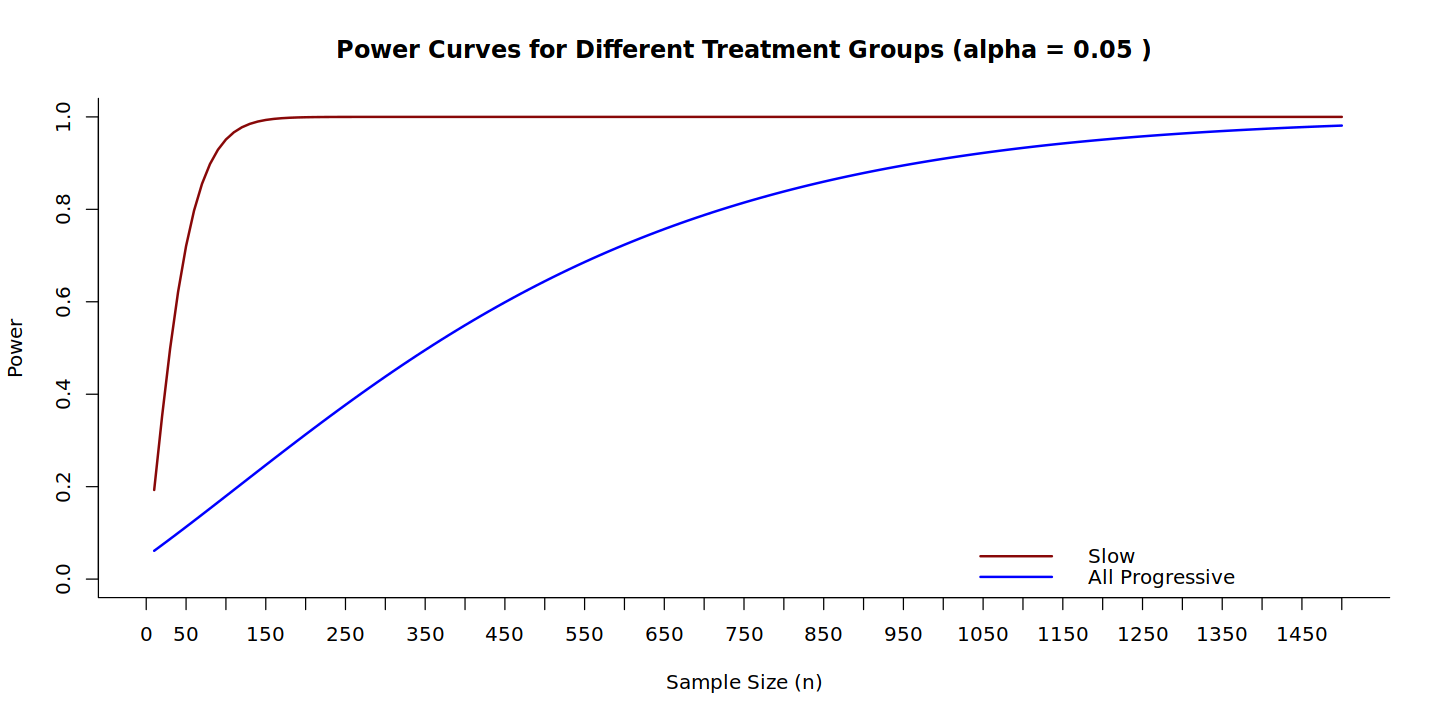

In [11]:
# Power Curve (main figure), save figure and related data

options(repr.plot.width = 12, repr.plot.height = 6)  # Adjust plot dimensions as needed

# Load necessary libraries
library(pwr)
library(ggplot2)

# Define parameters
sample_sizes <- seq(10, 1500, by = 10)  # Adjusted sample sizes

# Define a function to calculate Cohen's d as effect size
calculate_effect_size <- function(group1, group2) {
  mean_group1 <- mean(group1)
  mean_group2 <- mean(group2)
  sd_group1 <- sd(group1)
  sd_group2 <- sd(group2)
  pooled_sd <- sqrt(((length(group1) - 1) * sd_group1^2 + (length(group2) - 1) * sd_group2^2) / (length(group1) + length(group2) - 2))
  return(abs(mean_group1 - mean_group2) / pooled_sd)
}

# Define a function to calculate power curve
calculate_power_curve <- function(effect_size, sample_sizes, group1, group2, alpha) {
  power_values <- vector("numeric", length = length(sample_sizes))  # Vector to store power values
  for (i in seq_along(sample_sizes)) {
    power_values[i] <- pwr.t.test(d = effect_size, sig.level = alpha, power = NULL, n = sample_sizes[i])$power
  }
  return(power_values)
}

# Define a function to plot power curves
plot_power_curves <- function(alpha, color1 = "blue", color2 = "green") {
  plot(NULL, xlim = c(0, 1500), ylim = c(0, 1), xlab = "Sample Size (n)", ylab = "Power",
       main = paste("Power Curves for Different Treatment Groups (alpha =", alpha, ")"),
       xaxt = "n", bty = "l")
  axis(1, at = seq(0, 1500, by = 50))  # Add more x-axis ticks
  
  # Plot power curve for Slow group
  cdr_change_slow_placebo <- subset(cdr_change_slow, Treatment_Information_1 == "Placebo")
  cdr_change_slow_50mg <- subset(cdr_change_slow, Treatment_Information_1 == "LY3314814-50mg")
  effect_size_slow <- calculate_effect_size(cdr_change_slow_placebo$CDR_SOB_change, cdr_change_slow_50mg$CDR_SOB_change)
  power_curve_slow <- calculate_power_curve(effect_size_slow, sample_sizes, cdr_change_slow_placebo$CDR_SOB_change, cdr_change_slow_50mg$CDR_SOB_change, alpha)
  lines(sample_sizes, power_curve_slow, type = "l", col = color1, lty = 1, lwd = 2)
  
  # Plot power curve for Entire group
  effect_size_entire <- calculate_effect_size(cdr_change_placebo$CDR_SOB_change, cdr_change_50mg$CDR_SOB_change)
  power_curve_entire <- calculate_power_curve(effect_size_entire, sample_sizes, cdr_change_placebo$CDR_SOB_change, cdr_change_50mg$CDR_SOB_change, alpha)
  lines(sample_sizes, power_curve_entire, type = "l", col = color2, lty = 1, lwd = 2)
  
  # Add legend
  legend("bottomright", legend = c("Slow", "All Progressive"), col = c(color1, color2), lty = 1, lwd = 2, bty = "n")
}

# Save the data used for the plots
save_plot_data <- function(alpha, filename) {
  cdr_change_slow_placebo <- subset(cdr_change_slow, Treatment_Information_1 == "Placebo")
  cdr_change_slow_50mg <- subset(cdr_change_slow, Treatment_Information_1 == "LY3314814-50mg")
  effect_size_slow <- calculate_effect_size(cdr_change_slow_placebo$CDR_SOB_change, cdr_change_slow_50mg$CDR_SOB_change)
  power_curve_slow <- calculate_power_curve(effect_size_slow, sample_sizes, cdr_change_slow_placebo$CDR_SOB_change, cdr_change_slow_50mg$CDR_SOB_change, alpha)
  
  effect_size_entire <- calculate_effect_size(cdr_change_placebo$CDR_SOB_change, cdr_change_50mg$CDR_SOB_change)
  power_curve_entire <- calculate_power_curve(effect_size_entire, sample_sizes, cdr_change_placebo$CDR_SOB_change, cdr_change_50mg$CDR_SOB_change, alpha)
  
  plot_data <- data.frame(
    sample_size = rep(sample_sizes, 2),
    power = c(power_curve_slow, power_curve_entire),
    group = rep(c("Slow", "All Progressive"), each = length(sample_sizes))
  )
  
  write.csv(plot_data, filename, row.names = FALSE)
}

# Plot and save power curves for alpha = 0.05
output_path_0.05 <- "figures/Figure6.eps"
setEPS()
postscript(output_path_0.05)
plot_power_curves(alpha = 0.05, color1 = '#880808', color2 = "blue")
dev.off()

# Save data for alpha = 0.05
save_plot_data(alpha = 0.05, filename = "figures/Figure6.csv")

# Plot power curves for alpha = 0.05
plot_power_curves(alpha = 0.05, color1 = '#880808', color2 = "blue")